# Unzip folders after uploading them to the colab environment

In [1]:
import zipfile

zip_path = '/content/Banana.zip' #path in google drive environment
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [2]:
zip_path = '/content/banana masks.zip' # path in google drive environment
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Image Processing and Preparation

In [3]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
from torchvision.transforms import functional as TF
import torch.optim as optim

# Define BananaSegmentationDataset
class BananaSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def create_mask_from_json(self, json_path, image_size):
        with open(json_path) as f:
            data = json.load(f)
            mask = Image.new('L', image_size, 0)
            draw = ImageDraw.Draw(mask)

            for shape in data['shapes']:
                if shape['label'] == 'banana':
                    points = shape['points']
                    polygon = [(int(point[0]), int(point[1])) for point in points]
                    draw.polygon(polygon, outline=1, fill=1)

        return mask

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        json_name = img_name.replace('.JPG', '.json').replace('.png', '.json').replace('.jpeg', '.json')
        json_path = os.path.join(self.masks_dir, json_name)
        mask = self.create_mask_from_json(json_path, image.size)

        if self.transform:
            image = self.transform(image)
            mask = TF.resize(mask, (128, 128))  # Resize using torchvision.transforms.functional
            mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask


# Building the Neural Network

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class BananaSegmentationModelUpdated(nn.Module):
    def __init__(self):
        super(BananaSegmentationModelUpdated, self).__init__()

        # Initialize ResNet34 and use all layers up to the final convolutional block
        resnet = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4  # Include the final layer to get 512 channels
        )

        # Decoder layers
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Final convolution layer to produce the segmentation mask
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)  # 2 output channels


    def forward(self, x):
        # Encoder path
        e1 = self.encoder[0](x)      # Initial conv1 + bn1 + relu
        e2 = self.encoder[4](e1)     # First ResNet block
        e3 = self.encoder[5](e2)     # Second ResNet block
        e4 = self.encoder[6](e3)     # Third ResNet block
        encoded = self.encoder[7](e4)  # Final ResNet block

        # Decoder path
        d4 = self.up1(encoded)                    # Upsample encoded feature map
        d4 = torch.cat([d4, e4], dim=1)           # Skip connection with e4
        d4 = self.conv1(d4)

        d3 = self.up2(d4)
        d3 = torch.cat([d3, e3], dim=1)           # Skip connection with e3
        d3 = self.conv2(d3)

        d2 = self.up3(d3)
        d2 = torch.cat([d2, e2], dim=1)           # Skip connection with e2
        d2 = self.conv3(d2)

        d1 = self.up4(d2)
        d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)           # Skip connection with e1
        d1 = self.conv4(d1)

        # Final layer to get segmentation mask
        output = self.final_conv(d1)
        outputs = torch.nn.functional.interpolate(output, size=(128, 128), mode='bilinear', align_corners=False)

        return outputs

# Training the Model

In [5]:
# Directory paths
images_dir = r"/content/dataset/Banana"
masks_dir = r"/content/dataset/banana masks"

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# Initialize dataset and dataloaders
dataset = BananaSegmentationDataset(images_dir, masks_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BananaSegmentationModelUpdated().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

train_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 69.0MB/s]


Epoch [1/20], Loss: 0.2460
Epoch [2/20], Loss: 0.0299
Epoch [3/20], Loss: 0.0172
Epoch [4/20], Loss: 0.0143
Epoch [5/20], Loss: 0.0139
Epoch [6/20], Loss: 0.0132
Epoch [7/20], Loss: 0.0118
Epoch [8/20], Loss: 0.0109
Epoch [9/20], Loss: 0.0098
Epoch [10/20], Loss: 0.0097
Epoch [11/20], Loss: 0.0096
Epoch [12/20], Loss: 0.0083
Epoch [13/20], Loss: 0.0085
Epoch [14/20], Loss: 0.0085
Epoch [15/20], Loss: 0.0086
Epoch [16/20], Loss: 0.0070
Epoch [17/20], Loss: 0.0068
Epoch [18/20], Loss: 0.0077
Epoch [19/20], Loss: 0.0074
Epoch [20/20], Loss: 0.0073


# Visualizing the output

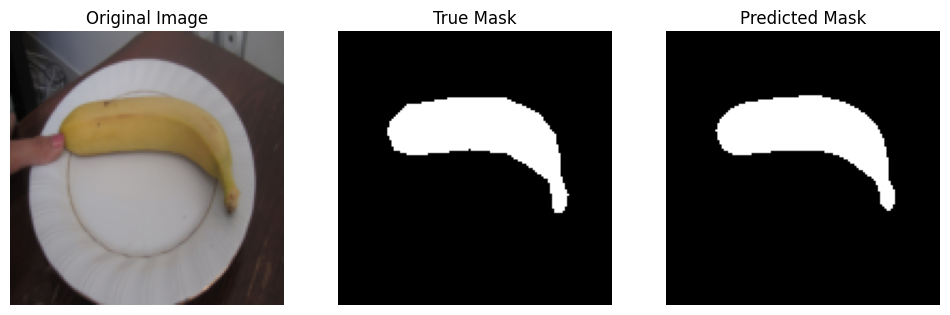

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import gc

# Function to visualize a sample image and its segmentation mask output
def visualize_segmentation_sample(model, dataset, device):
    gc.collect()  # Run garbage collection
    torch.cuda.empty_cache()  # Clear GPU cache if on GPU

    model.eval()  # Set the model to evaluation mode

    # Get a single sample from the dataset (image and ground truth mask)
    image, true_mask = val_dataset[3]  # use the first sample, or change index as needed
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image)  # Get model output
        predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # Convert logits to class labels and remove batch dim

    # Move tensors back to CPU and convert to NumPy arrays for visualization
    image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension and convert to HWC format
    image = (image * 255).astype(np.uint8)  # Convert to 0-255 range for display
    true_mask = true_mask.cpu().numpy()  # Convert ground truth mask to NumPy
    predicted_mask = predicted_mask.cpu().numpy()  # Convert predicted mask to NumPy

    # Plot the original image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Run visualization
visualize_segmentation_sample(model, dataset, device)